### A Jupyter notebook guiding through Data Exploration, Model Training, and Evaluation Process.

### Structure of the notebook:
    -0. Libraries and Common functions
    -1. Basic Data Statistics
    -2. Data Exploration
        -2.1 Univariate Analysis
            -2.1.1 Categorical Variables
            -2.1.2 Numeric Variables
        -2.2 Bivariate Analysis and analysis with more than two variables
            -2.2.1 Heatmap
            -2.2.2 Bivariate Analysis
    -3. Data Pre-processing
        -3.1 Missing and wrong value treatment
        -3.2 Drop unnecessary variables
        -3.3 Encoding of the categorical variables
        -3.4 Scaling
        -3.5 Baseline model
        -3.6 Scaling after transforming
        -3.7 Train Test Split
    -4. Modelling
        -4.1 No sampling
            -4.1.1 Logistic Regression
            -4.1.2 Random Forest
            -4.1.3 Gradient Boosting
        -4.2 With sampling
            -4.2.1 Logistic Regression
            -4.2.2 Random Forest
            -4.2.3 Gradient Boosting
            -4.2.4 XGBoost
            -4.2.5 Ensemble Models

## 0. Libraries and Common Functions

In [1]:
# Import required Python libraries for the analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import scipy
from scipy.stats import chi2_contingency
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from common_functions import plot_count_percentage_missing, describe_numeric_column, visualize_numeric_variables, visualize_correlations, visualize_categorical_impact, scatter_plot, visualize_numeric_impact
from utils import preprocess_data, scale_data, remove_skewness, evaluate_model_performance, save_model, get_rare_categories, feature_selection_with_rf, plot_feature_importances, train_evaluate_model
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

In [2]:
# Set the few options to view the output
pd.set_option('display.max_rows', 5000)

In [3]:
# Read the given input data from the Data sheet
cust_data = pd.read_csv("training_set.csv", low_memory=False)

## 1. Basic Data Statistics

In [4]:
# View the sample of the input data
cust_data.head()

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
0,0,57,21,168.0,60.0,F,MARRIED,No,Yes,No,...,No,No,0.0,0,0,0,30000,30000,1,True
1,1,5,20,90.0,16.5,F,SINGLE,No,No,No,...,No,No,0.0,0,0,0,50000,50000,1,True
2,2,38,22,158.0,55.0,F,MARRIED,No,No,No,...,No,No,2.0,0,4,1,100000,470000,2,False
3,3,38,25,160.0,65.0,F,MARRIED,No,No,No,...,No,No,0.0,0,0,0,20000,20000,1,True
4,4,26,22,174.0,67.0,M,SINGLE,No,No,No,...,No,No,0.0,0,0,0,100000,100000,1,True


In [5]:
# View the number of rows and columns present in the data
cust_data.shape

(99000, 24)

In [6]:
# View basic properties of the data like data type, count, non-null rows and total columns in the data
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              99000 non-null  int64  
 1   AGE             99000 non-null  int64  
 2   BMI             99000 non-null  int64  
 3   HEIGHT          99000 non-null  float64
 4   WEIGHT          99000 non-null  float64
 5   GENDER          99000 non-null  object 
 6   MARITAL_STATUS  99000 non-null  object 
 7   SMOKING         98996 non-null  object 
 8   DRINKING        99000 non-null  object 
 9   C1              99000 non-null  object 
 10  C2              99000 non-null  object 
 11  C3              99000 non-null  object 
 12  C4              99000 non-null  object 
 13  C5              99000 non-null  object 
 14  C6              99000 non-null  object 
 15  C7              98996 non-null  object 
 16  H1              98996 non-null  float64
 17  H2              99000 non-null 

#### Observations:
#### 1. Four variables like Smoking, C7, H1 and Outcome have some missing values.
#### 2. There seem to be 12 categorical variables and remaining either integer or float. Need to check whether they still have categories in the form of numbers.

In [7]:
# View the basic statistics of the data
cust_data.describe()

,ID,AGE,BMI,HEIGHT,WEIGHT,H1,H2,H3,H4,A1,A2,RISK
count,99000.000000,99000.000000,99000.000000,99000.000000,99000.000000,98996.000000,99000.000000,99000.000000,99000.000000,9.900000e+04,9.900000e+04,99000.000000
mean,50017.650606,29.495071,21.987929,155.605788,56.817050,0.292517,0.116253,0.271566,0.348970,1.678561e+05,2.905642e+05,1.287788
std,28868.212989,14.554692,4.094339,29.344342,20.729698,0.595090,0.378903,1.117687,0.908838,3.006440e+05,5.641221e+05,0.675428
min,0.000000,-35.000000,-25.000000,-157.000000,-73.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-5.000000e+04,1.000000
25%,25026.750000,22.000000,19.000000,155.000000,50.000000,0.000000,0.000000,0.000000,0.000000,1.300000e+04,5.000000e+04,1.000000
50%,50013.500000,30.000000,22.000000,164.000000,60.000000,0.000000,0.000000,0.000000,0.000000,7.000000e+04,1.000000e+05,1.000000
75%,75020.250000,39.000000,25.000000,171.000000,70.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,3.000000e+05,1.000000
max,99999.000000,71.000000,233.000000,205.000000,166.000000,9.000000,4.000000,37.000000,13.000000,1.400000e+07,2.281448e+07,4.000000


#### Observations:
#### 1. Columns like Age, BMI, Height and Weight have minimum values negative. By definition, they can not have negative values. Need to check later.
#### 2. Maximum value of BMI is 233 which is too high. Need to check those outliers.
#### 3. Values of Height seem to be in cm and Weight in kg.
#### 4. There is no description about H1, H2, H3 and H4. But they don't have any negative values.
#### 5. A1 and A2 also have no description. A1 has positive values and A2 seem to have positive as well as negative values.

In [8]:
# Get unique count for each variable
cust_data.nunique()

ID                99000
AGE                  73
BMI                  43
HEIGHT              239
WEIGHT              945
GENDER                2
MARITAL_STATUS        5
SMOKING               2
DRINKING              2
C1                    2
C2                    2
C3                    2
C4                    2
C5                    2
C6                    2
C7                    2
H1                    9
H2                    5
H3                   29
H4                   14
A1                 4282
A2                15686
RISK                  4
OUTCOME               2
dtype: int64

#### Observations:
#### 1. Categorical variables have low number of unique values.
#### 2. Most numeric variables have high number of unique values. Numeric variables with low unique values could be categories. Need to check for H1, H2, H3 and H4 to check whether they are categories or not.
#### 3. ID has all unique values. 
#### 4. Risk has 4 different categories and Outcome has 2. Need to check whether they are related to each other.

## 2. Data Exploration

### 2.1 Univariate Analysis

### 2.1.1 Categorical Variables

##### 2.1.1.1 ID

In [9]:
# View different values present in the ID column and its count
cust_data.ID.value_counts(dropna=False)

ID
99999    1
0        1
1        1
2        1
3        1
        ..
12       1
11       1
10       1
9        1
8        1
Name: count, Length: 99000, dtype: int64

#### Observations: There are 100000 unique IDs in the dataset. As it is having different unique value for each of the row, there is no way we can use this to categorize into categories of target variable. We need to drop this column later.

##### 2.1.1.2 Gender

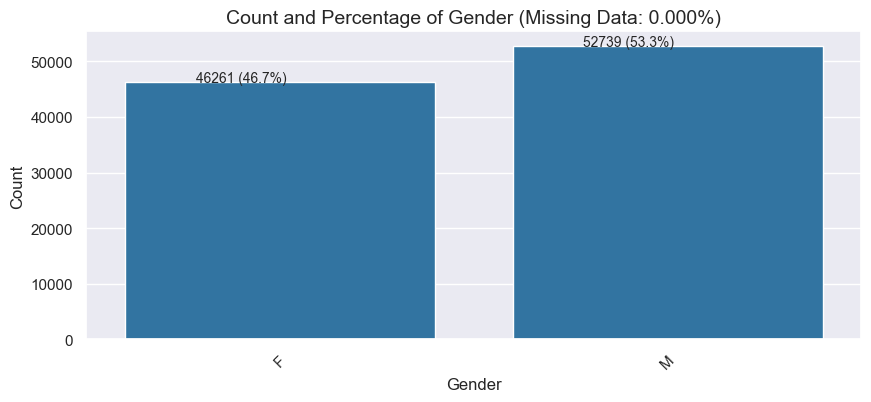

In [10]:
plot_count_percentage_missing(cust_data,'GENDER')

#### Observations: Male customers are higher than female ones. But there is no large gap in the percentages. No missing values present.

##### 2.1.1.3 Marital Status

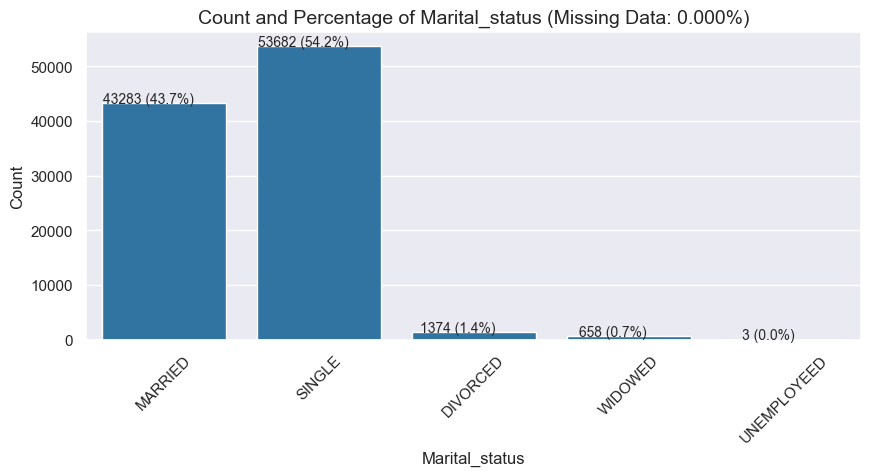

In [11]:
plot_count_percentage_missing(cust_data,'MARITAL_STATUS')

#### Observations: 
#### 1. Unemployment should not be a Marital Status. There are 3 rows having this category. This should be by mistake.
#### 2. Single customers are the largest. Married customers are in high numbers as well.
#### 3. Divorced and widowed customers are present in low numbers as well.
#### 4. No missing values present for this column.

##### 2.1.1.4 Smoking

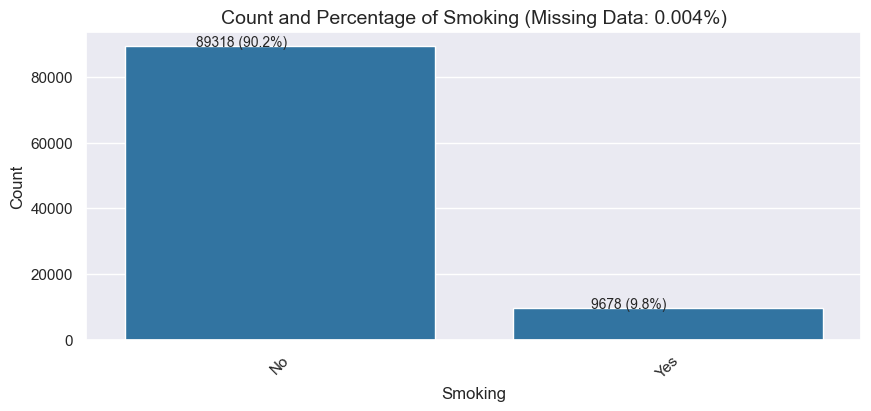

In [12]:
plot_count_percentage_missing(cust_data,'SMOKING')

#### Observations:
#### 1. There are 4 instances where value of Smoking is NaN. We need to fill the NaN values with some value.
#### 2. Majority of the customers don't smoke.

##### 2.1.1.5 Drinking

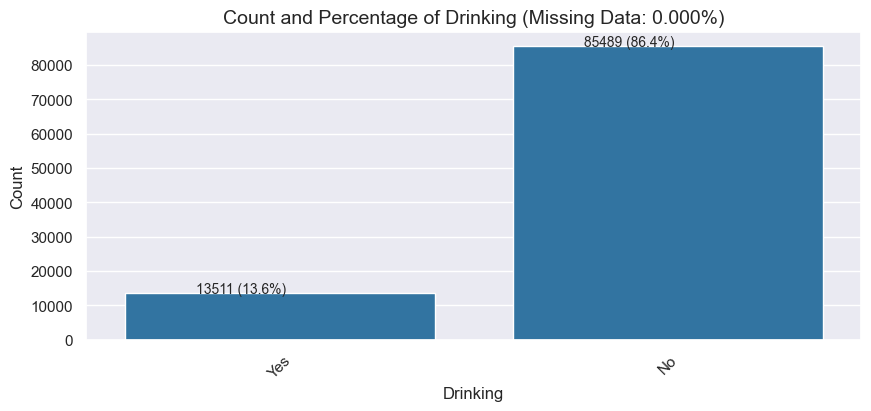

In [13]:
plot_count_percentage_missing(cust_data,'DRINKING')

#### Observations:
#### 1. Majority of the customers don't drink.
#### 2. No missing values in the data for drinking.

##### 2.1.1.6 C1

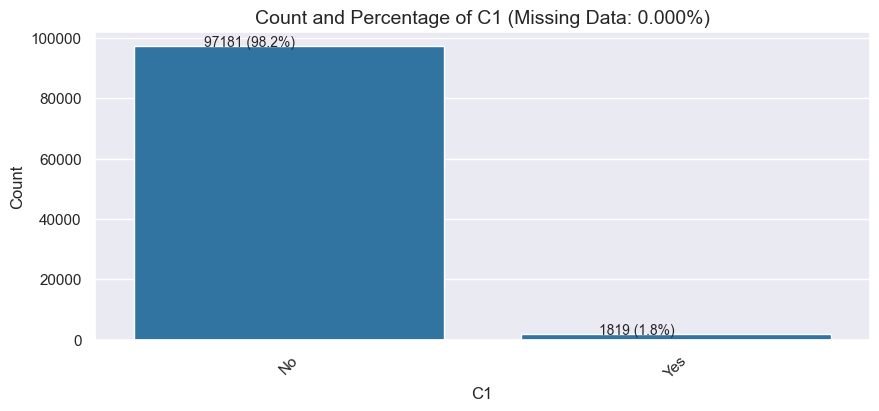

In [14]:
plot_count_percentage_missing(cust_data,'C1')

#### Observations:
#### 1. Overwhelming customers have C1 value as No.
#### 2. No missing value for C1.

##### 2.1.1.7 C2

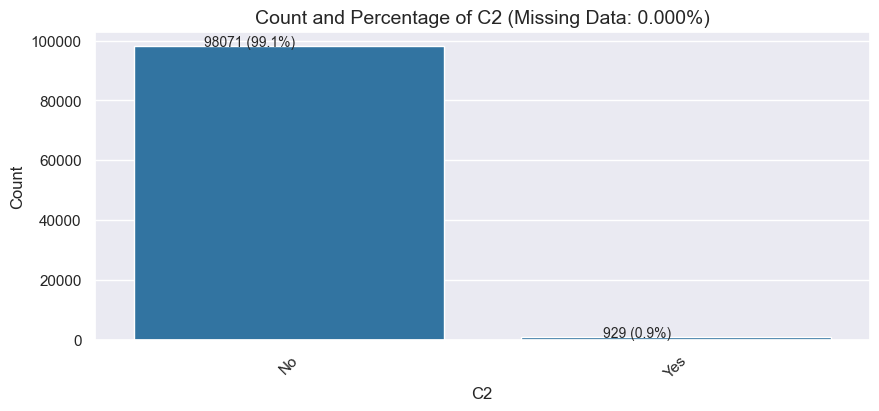

In [15]:
plot_count_percentage_missing(cust_data,'C2')

#### Observations:
#### 1. Overwhelming customers have C2 value as No.
#### 2. No missing value for C2.

##### 2.1.1.8 C3

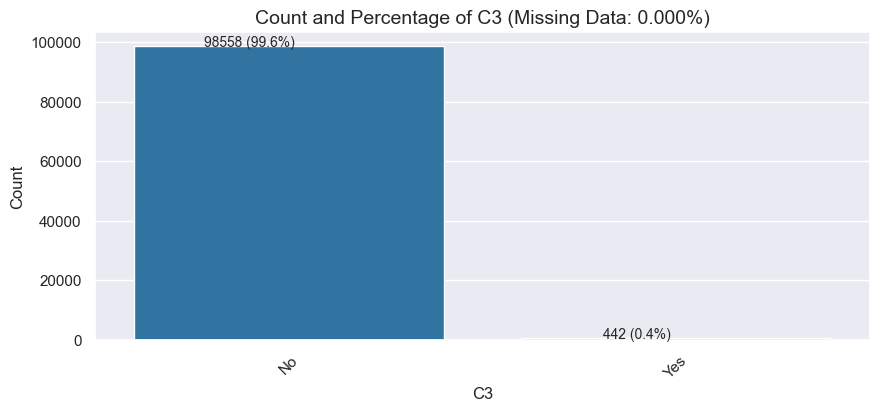

In [16]:
plot_count_percentage_missing(cust_data,'C3')

#### Observations:
#### 1. Overwhelming customers have C3 value as No.
#### 2. No missing value for C3.

##### 2.1.1.9 C4

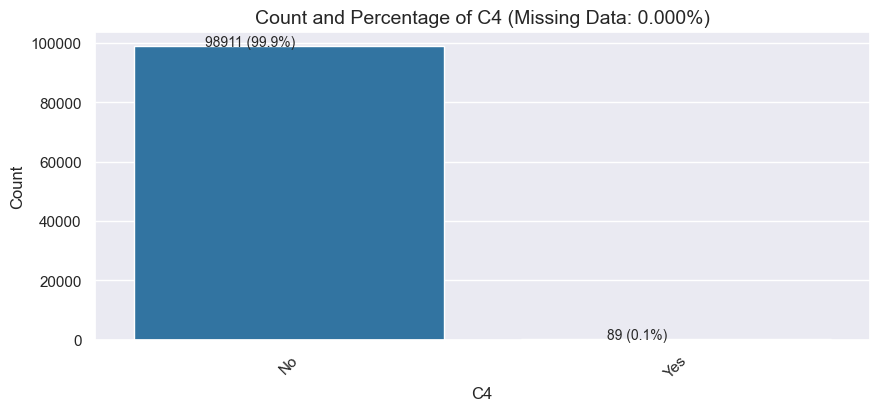

In [17]:
plot_count_percentage_missing(cust_data,'C4')

#### Observations:
#### 1. Overwhelming customers have C4 value as No.
#### 2. No missing value for C4.

##### 2.1.1.10 C5

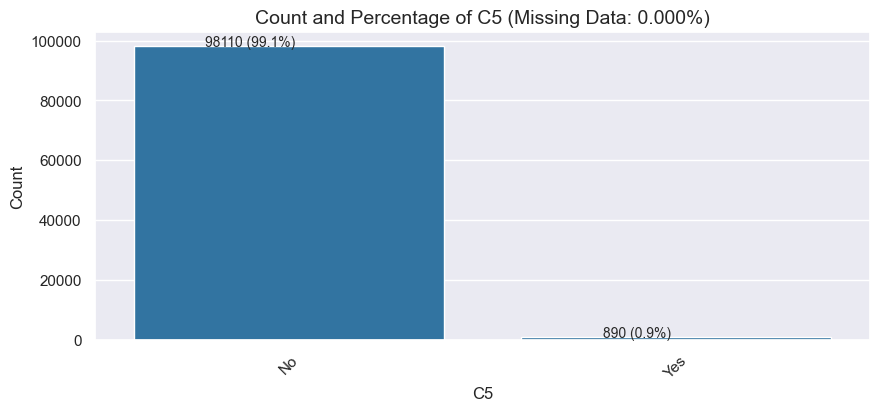

In [18]:
plot_count_percentage_missing(cust_data,'C5')

#### Observations:
#### 1. Overwhelming customers have C5 value as No.
#### 2. No missing value for C5.

##### 2.1.1.11 C6

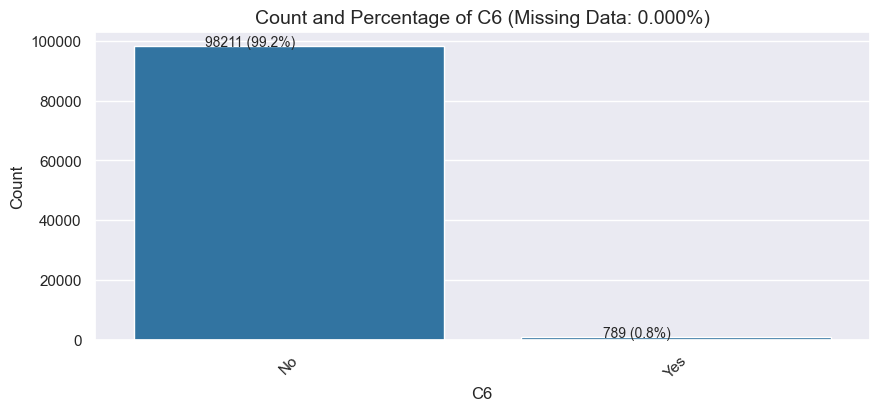

In [19]:
plot_count_percentage_missing(cust_data,'C6')

#### Observations:
#### 1. Overwhelming customers have C6 value as No.
#### 2. No missing value for C6.

##### 2.1.1.12 C7

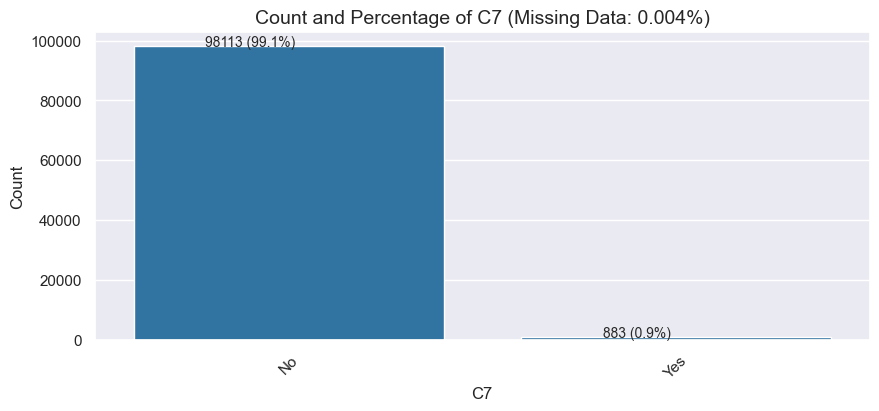

In [20]:
plot_count_percentage_missing(cust_data,'C7')

#### Observations:
#### 1. Overwhelming customers have C7 value as No.
#### 2. There are 4 instances having value as NaN. Need to fill in with proper value later.

##### 2.1.1.13 H1

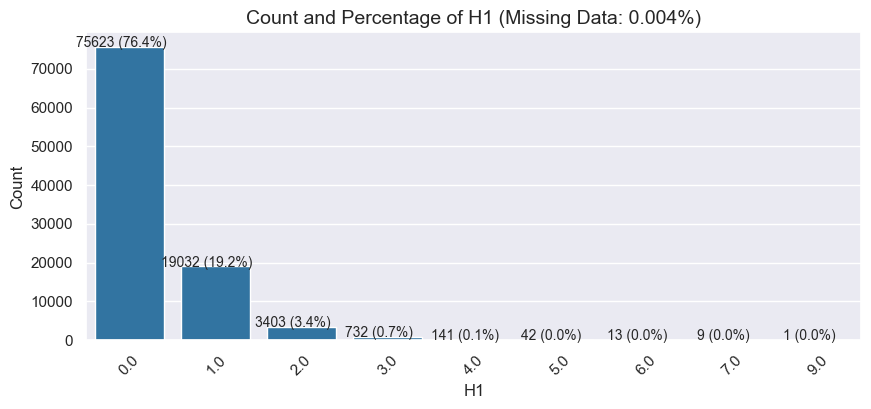

In [21]:
plot_count_percentage_missing(cust_data,'H1')

#### Observations: 
#### 1. Although H1 has numeric values, it has only few values.
#### 2. H1 seems to be ordinal variable.
#### 3. Count for 0,1 and 2 constitute 99% of the volume. Rest values are only 1%.
#### 4. There are 4 missing values in H1.

##### 2.1.1.14 H2

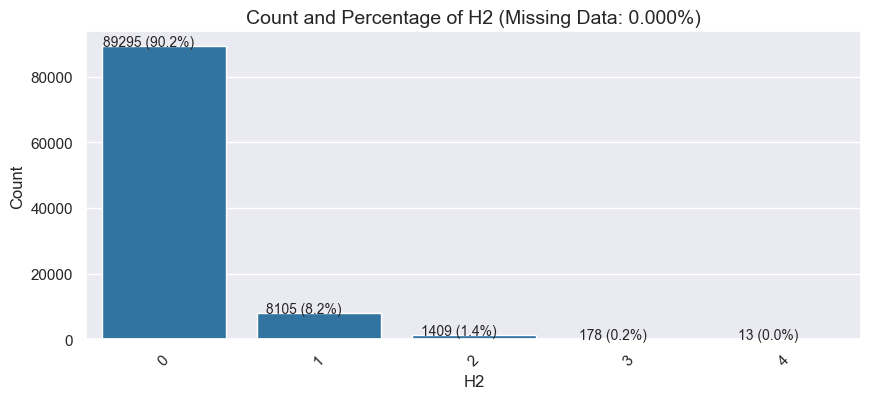

In [22]:
plot_count_percentage_missing(cust_data,'H2')

#### Observations: 
#### 1. Although H2 has numeric values, it has only few values.
#### 2. H2 seems to be ordinal variable.
#### 3. Count for 0,1 and 2 constitute more than 99.8% of the volume.
#### 4. No missing values in H2.

##### 2.1.1.15 H3

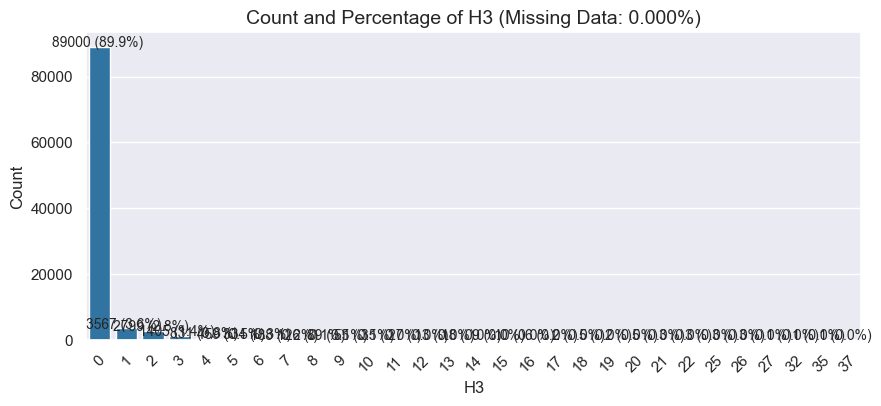

In [23]:
plot_count_percentage_missing(cust_data,'H3')

#### Observations: 
#### 1. No missing values in H3.
#### 2. H3 seem to have only integer values.
#### 3. Count for 0,1,2,3,4 and 5 constitute more than 99% of the volume.
#### 4. For values more than 5, we could keep it like that or bucket it into one category.

##### 2.1.1.16 H4

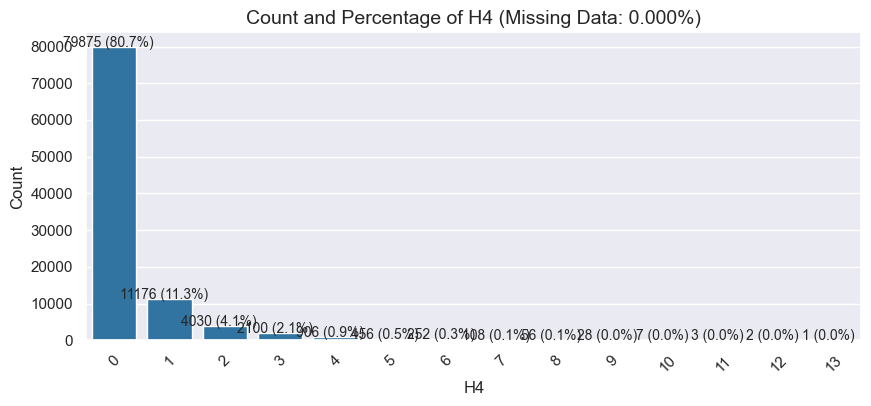

In [24]:
plot_count_percentage_missing(cust_data,'H4')

#### Observations: 
#### 1. No missing values in H4.
#### 2. H4 seem to have only integer values.
#### 3. Count for 0,1,2,3,4 constitute more than 99% of the volume.
#### 4. For values more than 4, we could either keep it like that or bucket it into one category.

##### 2.1.1.17 RISK

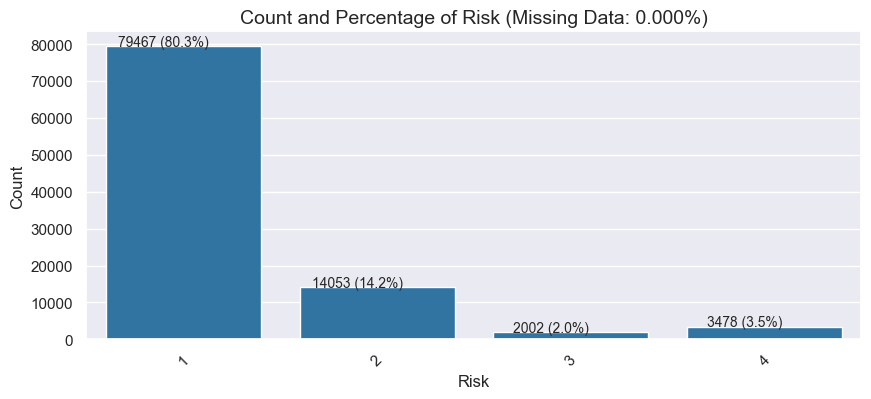

In [25]:
plot_count_percentage_missing(cust_data,'RISK')

#### Observations:
#### 1. Most of the customers have Risk 1.
#### 2. There are less people having Risk 3 or 4.
#### 3. No missing values for Risk.

##### 2.1.1.18 OUTCOME

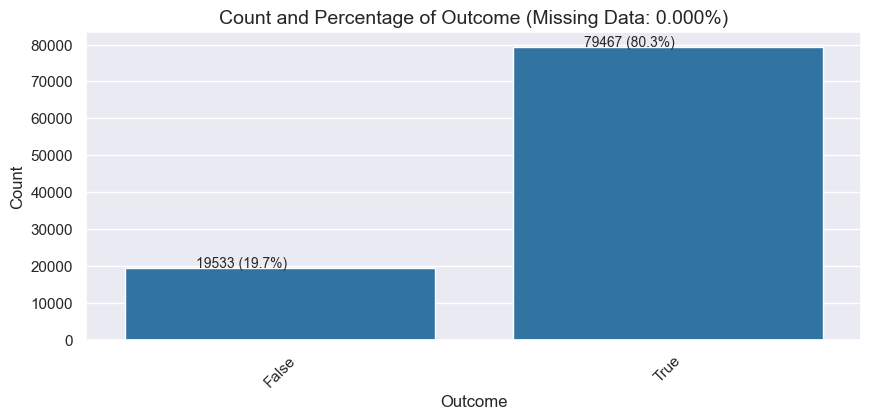

In [26]:
plot_count_percentage_missing(cust_data,'OUTCOME')

#### Observations:
#### 1. Outcome variable as high number of values as True.
#### 2. There are 2 instances which don't have value. We may need to fill in with some value before applying in any model.
#### 3. Count values of Outcome variables' True seem to be almost same as count of Risk ratings' 1 value. We may need to check their correlation later.

### 2.1.2 Numeric Variables

##### 2.1.2.1 Age

In [27]:
describe_numeric_column(cust_data, "AGE")

Description of 'AGE':
count    99000.000000
mean        29.495071
std         14.554692
min        -35.000000
25%         22.000000
50%         30.000000
75%         39.000000
max         71.000000
Name: AGE, dtype: float64

No missing values found in 'AGE'


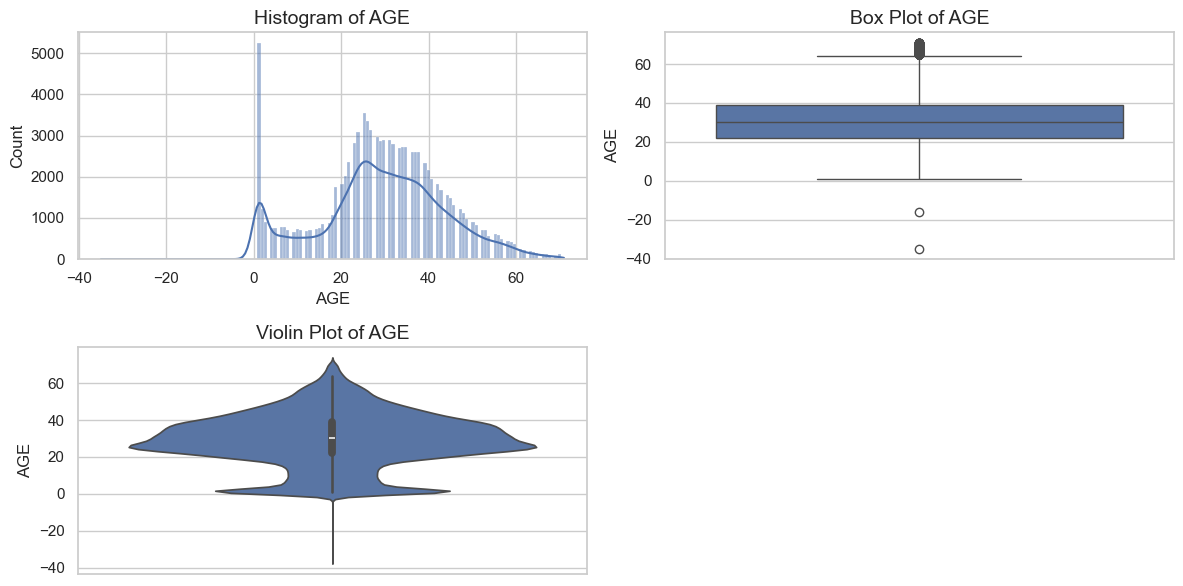

In [28]:
visualize_numeric_variables(cust_data, ['AGE'])

#### Observations:
#### 1. Majority of the customers are in the age range of 20 to 40.
#### 2. There are 2 instances where age is less than zero. For these 2 instances, by just looking at other values, it seems like they are wrongly given negative values. For person with age as -16, he is Single, weight as 51 and height as 158. His age should be 16. Similarly, for other person with age as -35, he is Married, weight as 85 and height as 180. His age should be 35.
#### 3. Till the age 20, there are constant number of customers. After Age 40, customers seem to decline steadily.
#### 4. Almost 5% of the customers have Age as 1. Babies become customers within a year.
#### 5. Maximum value is 71.

##### 2.1.2.2 BMI

In [29]:
describe_numeric_column(cust_data, "BMI")

Description of 'BMI':
count    99000.000000
mean        21.987929
std          4.094339
min        -25.000000
25%         19.000000
50%         22.000000
75%         25.000000
max        233.000000
Name: BMI, dtype: float64

No missing values found in 'BMI'


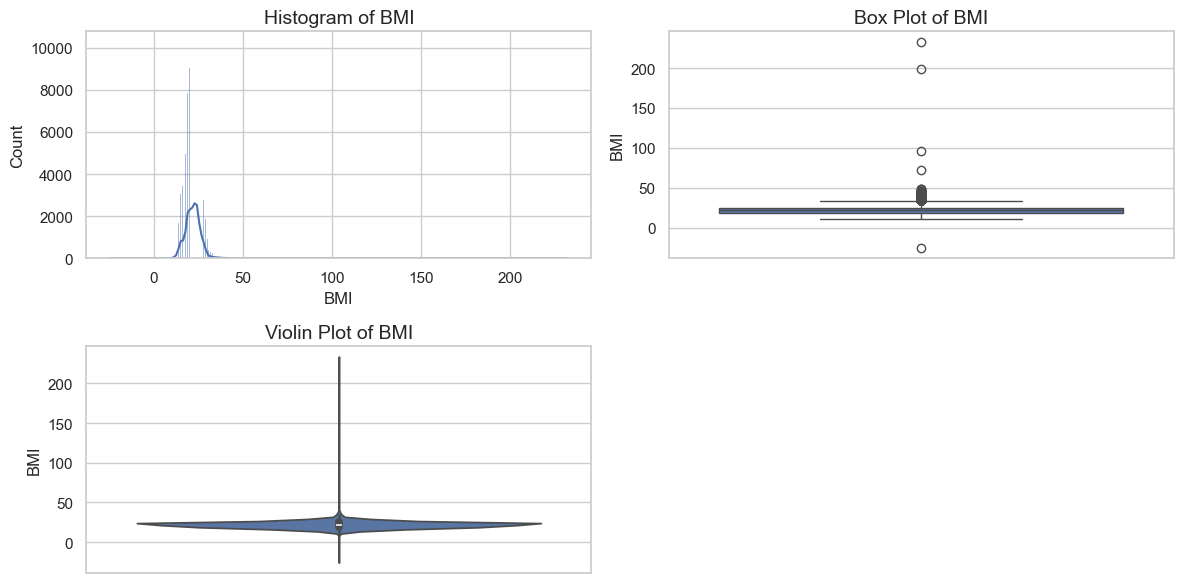

In [30]:
visualize_numeric_variables(cust_data, ['BMI'])

#### Observations:
#### 1. Majority of the BMI values seem to follow normal distribution.
#### 2. There is one instance where BMI is less than zero which is not possible. By looking at that value, it seems like it is by mistake. Need to correct that.
#### 3. By looking at some values greater than 50, their calculations seem wrong. We may need to manually change those records or remove them.

##### 2.1.2.3 Height

In [31]:
describe_numeric_column(cust_data, "HEIGHT")

Description of 'HEIGHT':
count    99000.000000
mean       155.605788
std         29.344342
min       -157.000000
25%        155.000000
50%        164.000000
75%        171.000000
max        205.000000
Name: HEIGHT, dtype: float64

No missing values found in 'HEIGHT'


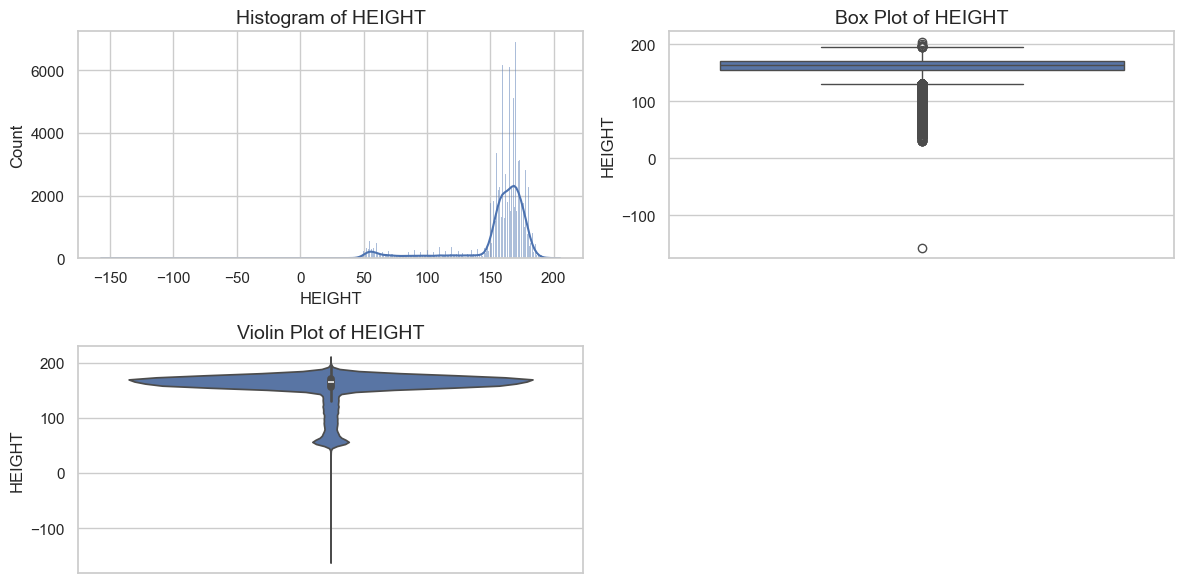

In [32]:
visualize_numeric_variables(cust_data, ['HEIGHT'])

#### Observations:
#### 1. Height less than zero is not possible in real life. Seems to be by mistake.
#### 2. Height greater than 200 cm is rare but possible sometimes. Only 1 such instance.
#### 3. Distribution is normal but have a tail.

##### 2.1.2.4 Weight

In [33]:
describe_numeric_column(cust_data, "WEIGHT")

Description of 'WEIGHT':
count    99000.000000
mean        56.817050
std         20.729698
min        -73.000000
25%         50.000000
50%         60.000000
75%         70.000000
max        166.000000
Name: WEIGHT, dtype: float64

No missing values found in 'WEIGHT'


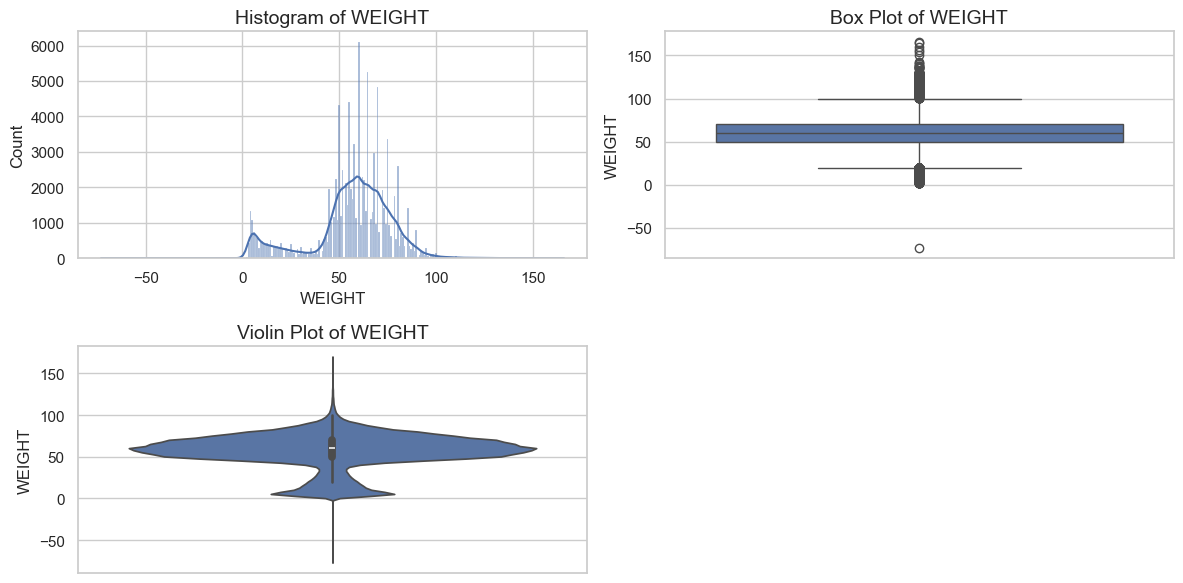

In [34]:
visualize_numeric_variables(cust_data, ['WEIGHT'])

#### Observations:
#### 1. There is a normal distribution for weight if we take into account only the adults. But there is one more peak seen for the babies.
#### 2. There is one instance where weight is less than zero which is not possible in real life.

##### 2.1.2.5 A1

In [35]:
describe_numeric_column(cust_data, "A1")

Description of 'A1':
count    9.900000e+04
mean     1.678561e+05
std      3.006440e+05
min      0.000000e+00
25%      1.300000e+04
50%      7.000000e+04
75%      1.500000e+05
max      1.400000e+07
Name: A1, dtype: float64

No missing values found in 'A1'


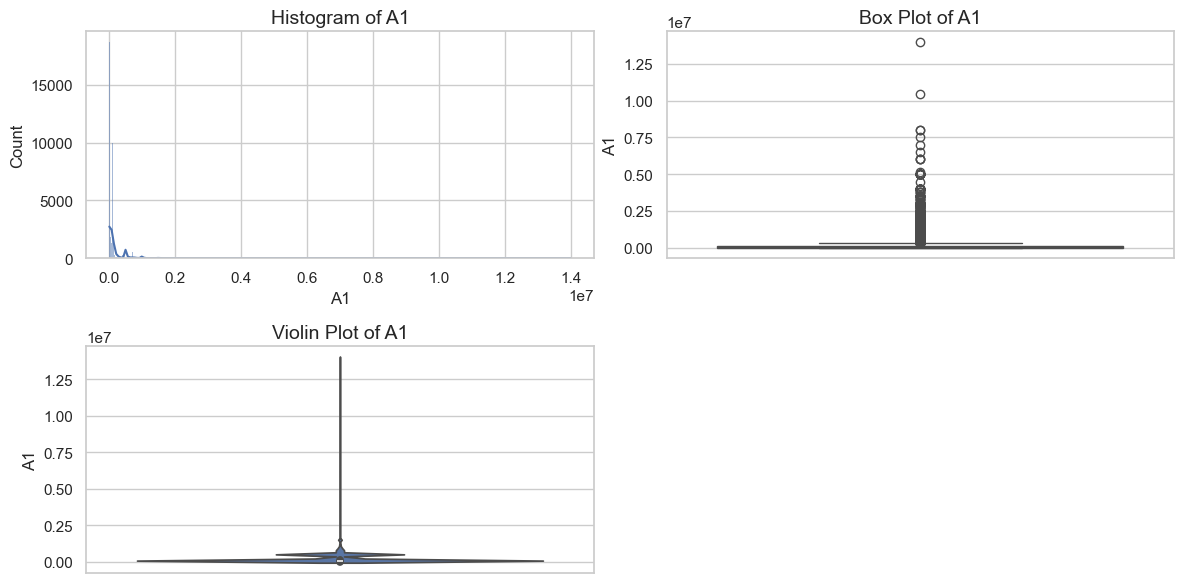

In [36]:
visualize_numeric_variables(cust_data, ['A1'])

#### Observations:
#### 1. There seem to be two long peaks and a long tail for A1 variable.
#### 2. No missing values for A1.

##### 2.1.2.6 A2

In [37]:
describe_numeric_column(cust_data, "A2")

Description of 'A2':
count    9.900000e+04
mean     2.905642e+05
std      5.641221e+05
min     -5.000000e+04
25%      5.000000e+04
50%      1.000000e+05
75%      3.000000e+05
max      2.281448e+07
Name: A2, dtype: float64

No missing values found in 'A2'


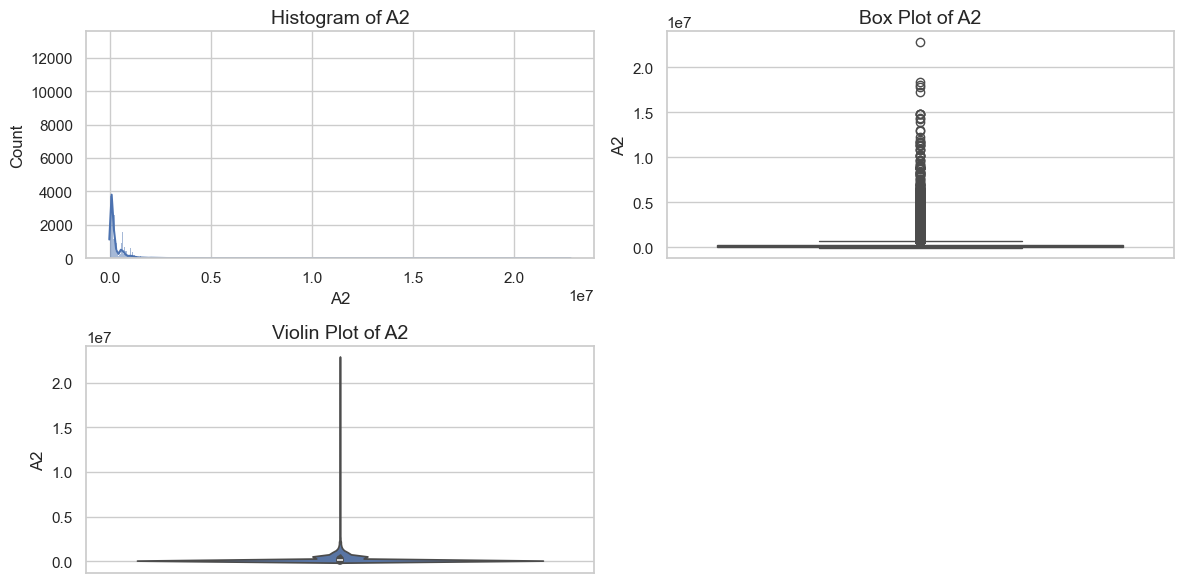

In [38]:
visualize_numeric_variables(cust_data, ['A2'])

#### Observations:
#### 1. There seem to be two peaks and a long tail for A2 variable.
#### 2. No missing values for A2.
#### 3. Seems to be in normal distribution.

### 2.2 Bivariate Analysis and analysis with more than two variables

#### 2.2.1 Heatmap

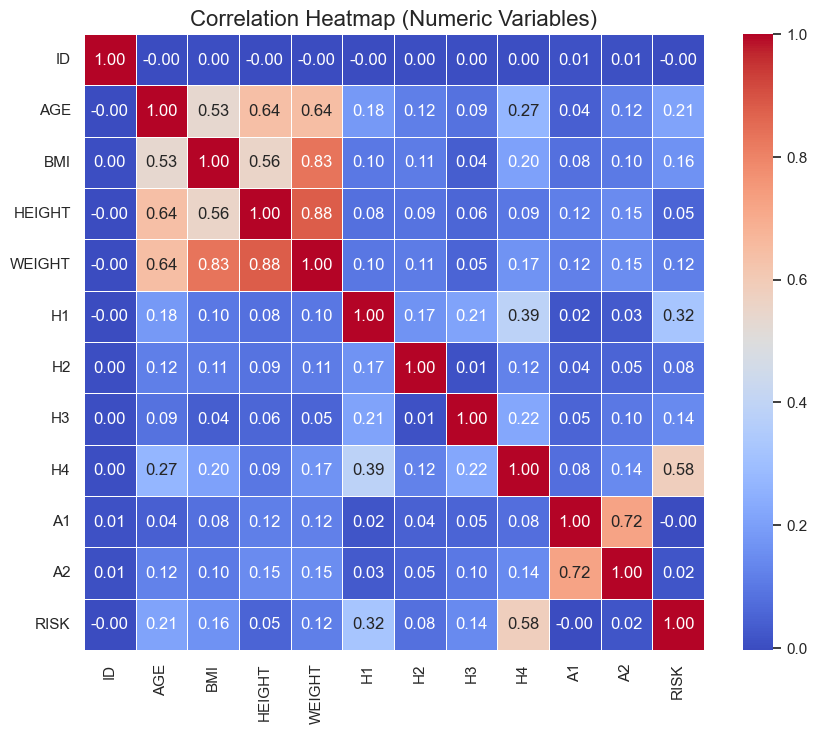

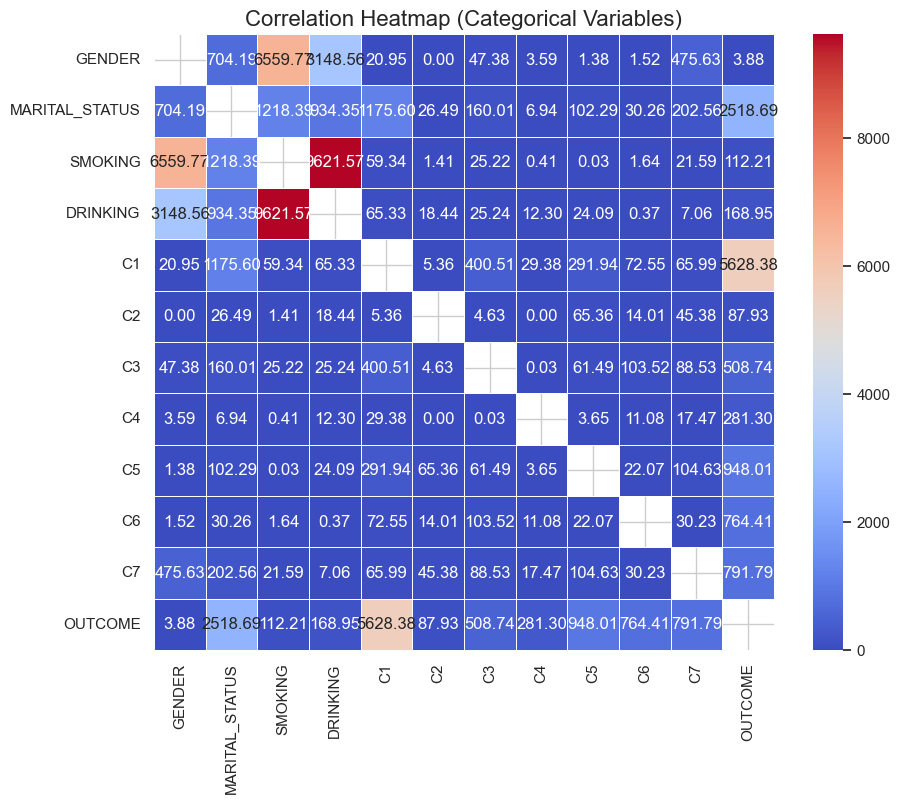

In [39]:
visualize_correlations(cust_data)

#### Observations:
#### 1. BMI, Height and Weight seem to be highly correlated as per expectation and definition. We may need to remove couple of variables.
#### 2. Age also seem to have a positive correlation with BMI, Height and Weight.
#### 3. A1 and A2 seem to have a high correlation as well.
#### 4. H4 seem to have a moderate correlation with Risk rating.
#### 5. Smoking and Drinking seem to have correlation between each other.
#### 6. Categorical variables need to be seen with a pich of salt by looking at the probability as well.

##### 2.2.2.1 Analysis of categorical variables with respect to Target Variable Outcome

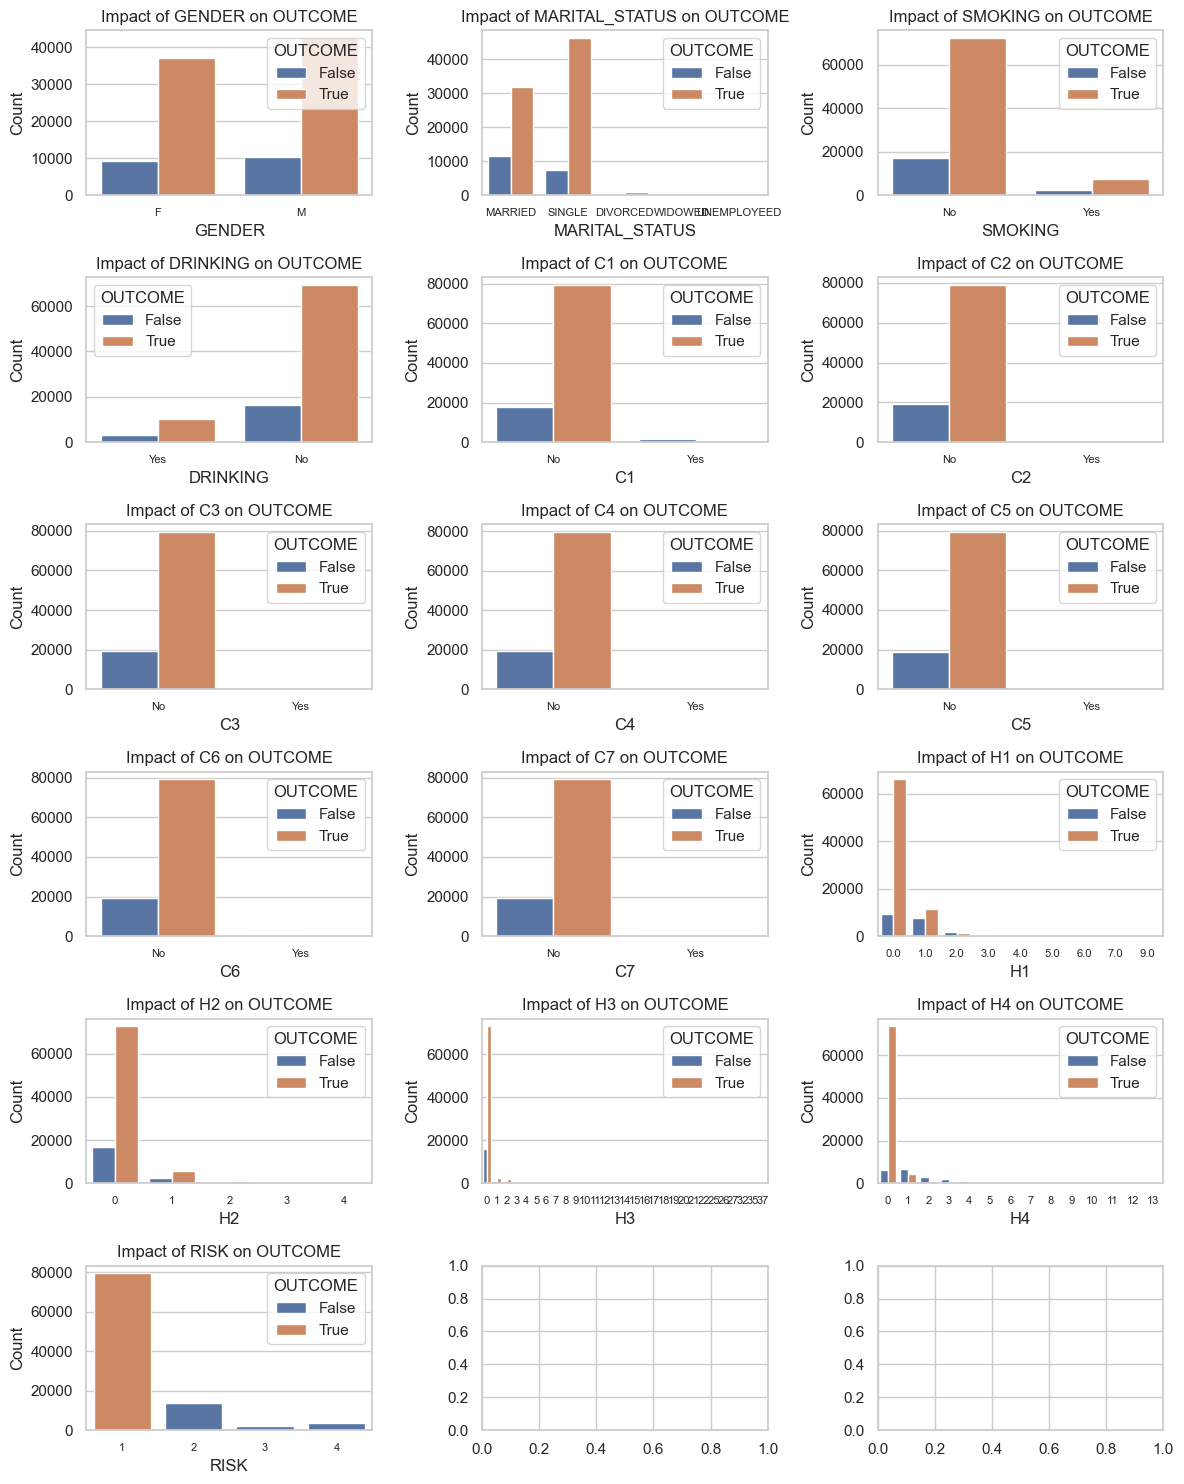

In [40]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'SMOKING', 'DRINKING', 'C1', 'C2','C3','C4','C5','C6','C7','H1','H2','H3','H4','RISK']
visualize_categorical_impact(cust_data, categorical_columns)

#### Observations: 
#### 1. Genderwise distribution seem to be similar for Outcome.
#### 2. Married customers seem to be on a higher risk than single customers.
#### 3. If customer is having Smoking or Drinking, then there is a slight higher risk.
#### 4. Distribution of C1, C2, C3, C4, C5, C6 and C7 seem to be similar.

##### 2.2.2.2 Analysis of Numeric variables with respect to Target variable

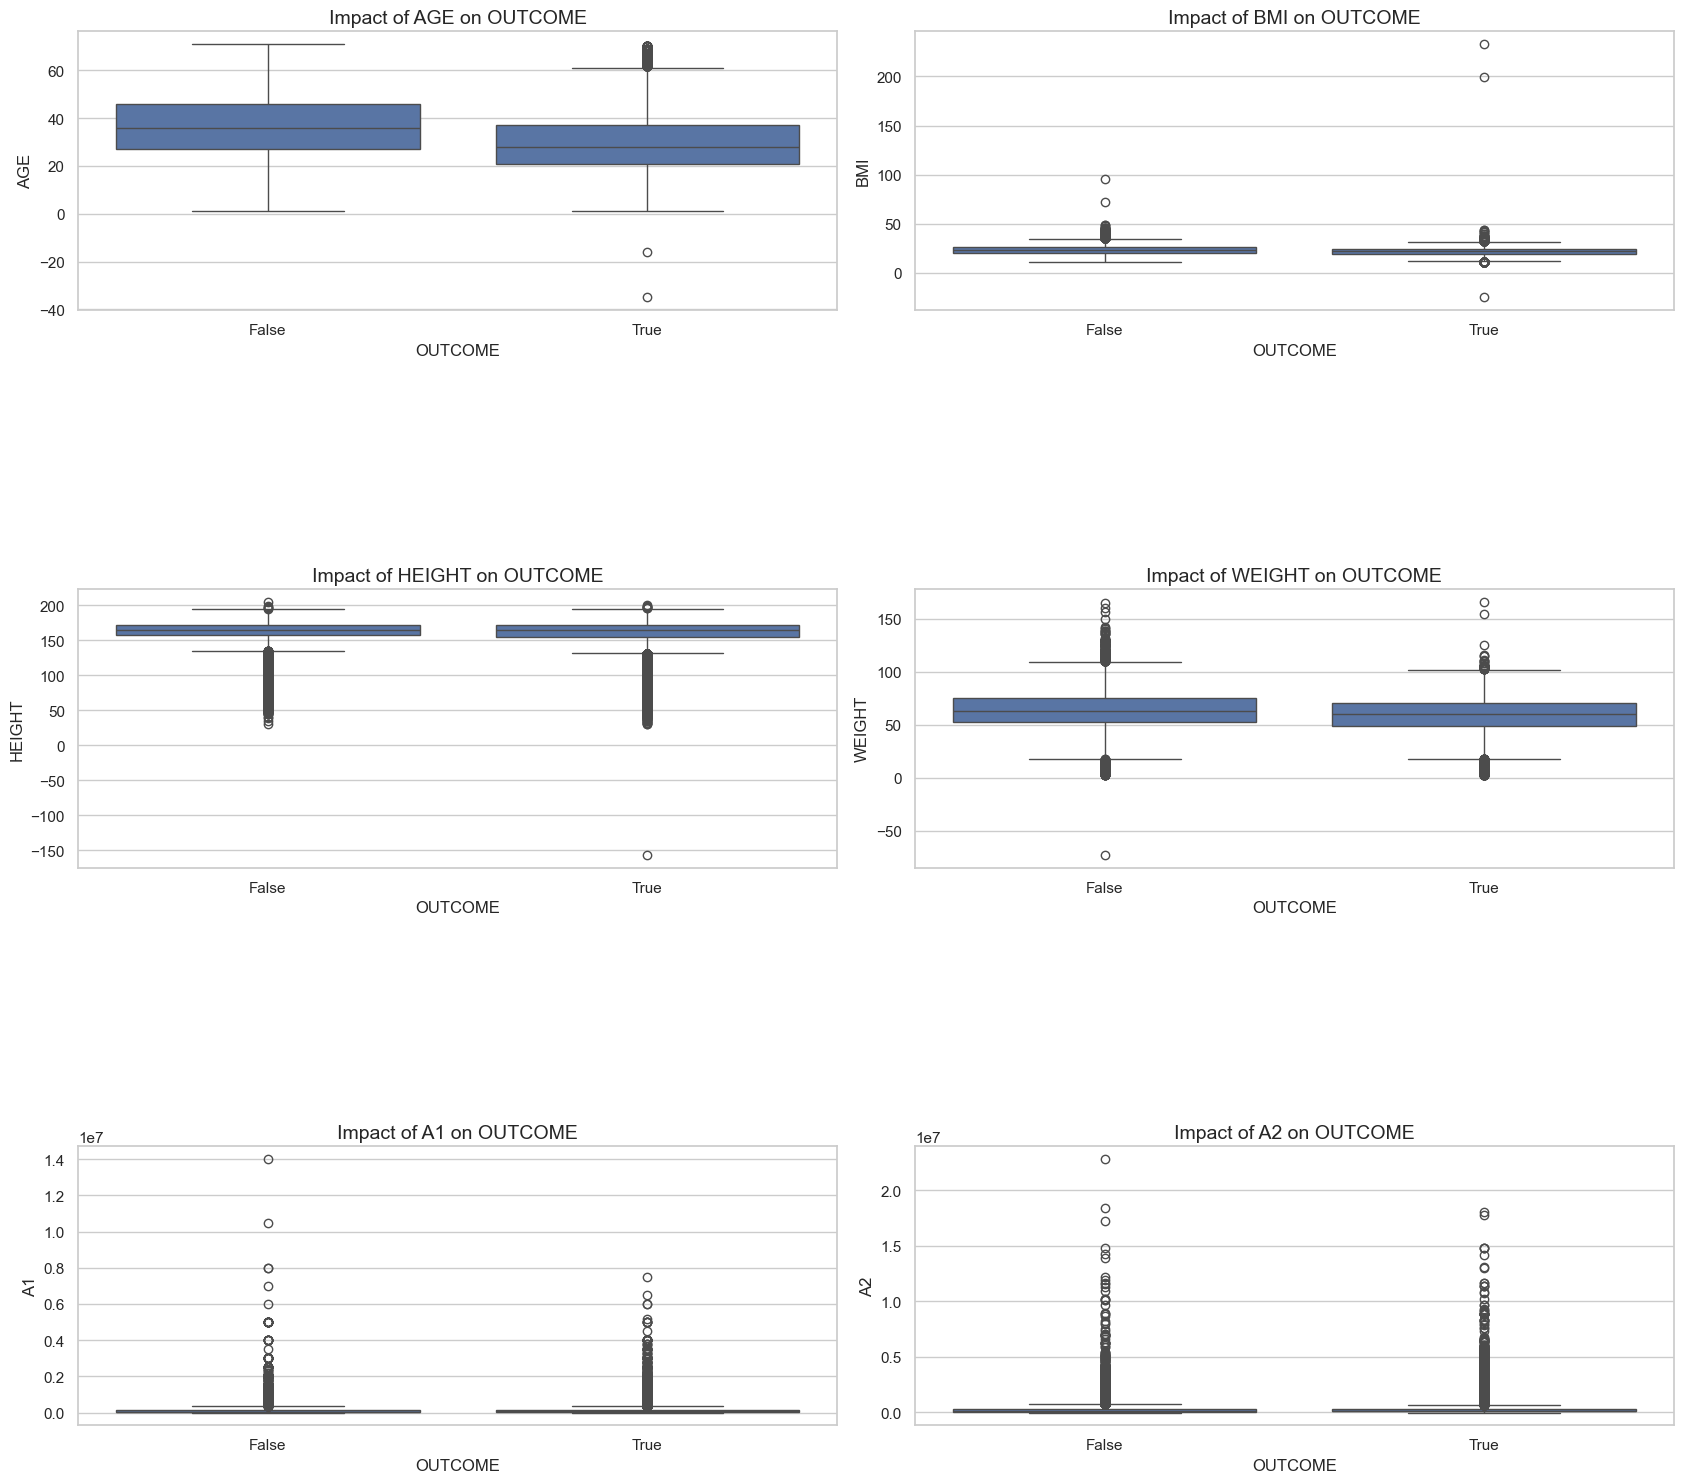

In [41]:
numerical_columns = ['AGE', 'BMI', 'HEIGHT', 'WEIGHT', 'A1', 'A2']
visualize_numeric_impact(cust_data, numerical_columns)

##### 2.2.2.3 Analysis of categorical variables with each other

In [42]:
# View the distribution of Risk and Outcome through Contingency table
pd.crosstab(cust_data['RISK'], cust_data['OUTCOME'])

OUTCOME,False,True
RISK,,
1,0,79467
2,14053,0
3,2002,0
4,3478,0


In [43]:
# C1 vs Outcome variable analysis
# create a contingency table of the two categorical variables
contingency_table = pd.crosstab(cust_data['SMOKING'], cust_data['DRINKING'])

# perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# print the results
print('Chi-square statistic:', chi2)
print('P-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

Chi-square statistic: 9621.574631549762
P-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[77127.85597398 12190.14402602]
 [ 8357.14402602  1320.85597398]]


#### Observations:
#### 1. Statistical tests show a strong correlation between C1, C2, C3, C4, C5, C6 and C7.
#### 2. Statistical tests show a corelation between C1 to C7 variables and Outcome variable.
#### 3. But these variables have imbalanced distribution of the levels for those features. Hence, not sure whether to remove just on the basis of statistical tests.

##### 2.2.2.4 Analysis of other pairs

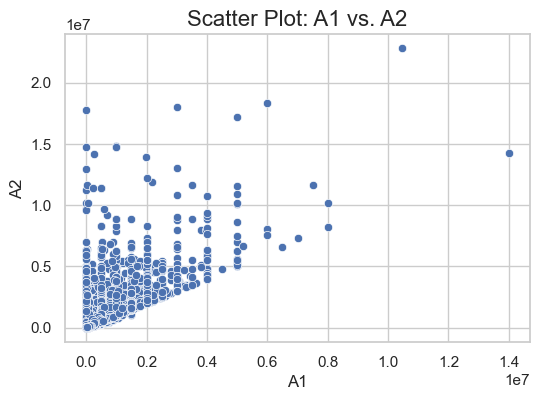

In [44]:
scatter_plot(cust_data, 'A1', 'A2')

## 3. Data Pre-processing

#### Missing values percentage is very small in the total dataset even less than 0.1%. So, one easy and quick way is to ignore these records and remove those records.
#### But, approach of imputing is used whenever is possible by doing some assumptions (e.g. BMI formula and mistakes in data collection)

### 3.1 Current State

In [45]:
# See the rows with Marital status as Unemployeed
cust_data[cust_data['MARITAL_STATUS']=='UNEMPLOYEED']

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
511,516,37,25,183.0,84.0,M,UNEMPLOYEED,No,No,No,...,No,No,0.0,0,0,0,0,80000,1,True
19455,19685,23,15,162.0,40.0,F,UNEMPLOYEED,No,No,No,...,No,No,0.0,0,0,1,109000,109000,2,False
97497,98485,27,21,162.0,55.0,F,UNEMPLOYEED,No,No,No,...,No,No,0.0,0,0,0,500000,620000,1,True


In [46]:
# Check for the rows which has Age values as negative
cust_data[cust_data['AGE']<0]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
36299,36686,-16,20,158.0,51.0,M,SINGLE,No,No,No,...,No,No,0.0,0,0,0,80000,80000,1,True
93748,94705,-35,26,180.0,85.0,M,MARRIED,Yes,Yes,No,...,No,No,0.0,0,0,0,2000000,2000000,1,True


In [47]:
# Check for the rows which has Height value as negative
cust_data[cust_data['HEIGHT']<0]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
53962,54522,25,23,-157.0,57.0,F,SINGLE,No,No,No,...,No,No,0.0,0,0,0,109000,109000,1,True


In [48]:
# Check for the rows which has Weight value as negative
cust_data[cust_data['WEIGHT']<0]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
84645,85517,51,25,170.0,-73.0,M,MARRIED,No,No,No,...,No,No,1.0,0,0,3,20000,1270000,2,False


In [49]:
# Check for the rows which has BMI value as negative
cust_data[cust_data['BMI']<0]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
36495,36882,50,-25,181.0,83.0,M,MARRIED,No,No,No,...,No,No,0.0,0,1,0,47280,47280,1,True


In [50]:
# Check for the rows which has BMI value as negative
cust_data[cust_data['BMI']>50]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
3290,3333,27,233,158.0,48.0,F,SINGLE,No,No,No,...,No,No,0.0,0,0,0,500000,500000,1,True
6719,6789,18,96,155.0,43.0,F,SINGLE,No,No,No,...,No,No,1.0,0,0,0,1000000,1000000,2,False
52658,53210,46,72,176.0,95.0,M,MARRIED,Yes,No,Yes,...,No,No,1.0,0,0,2,450000,350000,2,False
76888,77688,45,199,168.0,75.0,M,MARRIED,No,No,No,...,No,No,1.0,1,1,0,1000000,2081429,1,True


In [51]:
# Check if BMI Calculation is correct or not based on the formula of Weight and Height values.
# BMI = Weight(in kg)/Height(m)*Height(m)
# Get the rows which does not have same calculation as the calculation by formula
cust_data[(cust_data['WEIGHT'] > 150) & (cust_data['HEIGHT'] < 70)]

,ID,AGE,BMI,HEIGHT,WEIGHT,GENDER,MARITAL_STATUS,SMOKING,DRINKING,C1,...,C6,C7,H1,H2,H3,H4,A1,A2,RISK,OUTCOME
3324,3368,41,25,69.0,166.0,M,MARRIED,No,No,No,...,No,No,0.0,0,0,0,95000,70000,1,True
7698,7776,31,21,49.0,154.0,F,MARRIED,No,No,No,...,No,No,0.0,0,0,0,100000,100000,1,True
8758,8854,22,20,50.0,160.0,F,SINGLE,No,No,No,...,No,No,0.0,0,0,0,30000,30000,2,False
77094,77896,33,23,55.0,156.0,M,SINGLE,No,No,No,...,No,No,1.0,0,0,0,150000,150000,4,False
87766,88675,43,24,65.0,165.0,F,SINGLE,No,No,Yes,...,No,No,1.0,0,0,2,500000,550000,4,False


#### Observations: 
#### It is highly unlikely that people can have Weight so high (>150 kg) and height less than 70cm.
#### It seems that for these 5 entries, Wight and Height values are changed by their respective values. If we assume that then the calculations are correct. In view of that, we will keep the BMI values intact as they are more likely to be correct.

### 3.2 Pre-processing Pipeline

In [52]:
rare_cats = get_rare_categories(cust_data, ['H1','H2','H3','H4'])
cust_data_prepoc = preprocess_data(cust_data, rare_categories= rare_cats)

c:\Users\Megha\PycharmProjects\pythonProject\utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obese_cust['BMI2'] = round((obese_cust['WEIGHT'] / (obese_cust['HEIGHT'] / 100)) / (obese_cust['HEIGHT'] / 100)).astype(int)
c:\Users\Megha\PycharmProjects\pythonProject\utils.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode().iloc[0])  # Fill with mode for categorical columns


In [53]:
cust_data_scaled = scale_data(cust_data_prepoc)

### 3.3 Baseline model

In [54]:
# Split the target variable into separate dataframe 
X = cust_data_scaled.drop(["OUTCOME"], axis=1)
y = cust_data_scaled["OUTCOME"]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Simple Baseline model which is logistic regression to understand the baseline performance of the model
baseline_lr = LogisticRegression(random_state = 42)
# Fit the baseline model
baseline_lr.fit(X_train, y_train)
# Predictions for the baseline model
y_pred = baseline_lr.predict(X_test)
y_pred_proba = baseline_lr.predict_proba(X_test)[:, 1]

Precision: 0.716
Recall: 0.628
F1 Score: 0.669

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93     15969
           1       0.72      0.63      0.67      3831

    accuracy                           0.88     19800
   macro avg       0.81      0.78      0.80     19800
weighted avg       0.88      0.88      0.88     19800



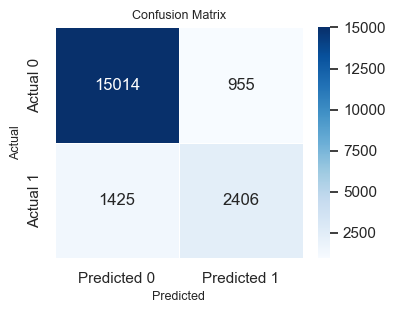

ROC AUC: 0.847


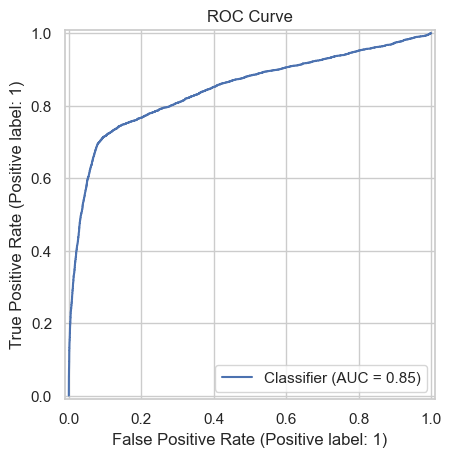

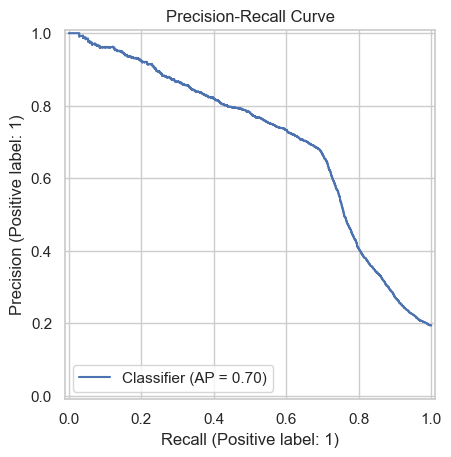

In [55]:
evaluate_model_performance(y_test, y_pred, y_pred_proba)

#### Observations: 
#### 1. As in this case, target variable is imbalanced, accuracy score is not the proper metric. Instead, F1 score or precision/recall or ROC AUC Score would be better option.
#### 2. Recall is moderate i.e. 62% and F1 Score is around 66%. Precision is good (72%)
#### 3. Here, they would like to detect the customers with a risk. So, Recall and F1 score could be better metric for this. Again, we would understand this better by talking with business people.

In [56]:
#cust_data_skew = remove_skewness(cust_data_prepoc)
cust_data_scale2 = scale_data(cust_data_prepoc)

In [57]:
# Split the target variable into separate dataframe
cust_data_copy = cust_data_scale2.copy()
X = cust_data_copy.drop(["OUTCOME"], axis=1)
y = cust_data_copy["OUTCOME"]

## 4. Modelling

### 4.1 No Sampling

### 4.1.1 Logistic Regression

c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Precision: 0.680
Recall: 0.669
F1 Score: 0.674

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     15893
           1       0.68      0.67      0.67      3907

    accuracy                           0.87     19800
   macro avg       0.80      0.80      0.80     19800
weighted avg       0.87      0.87      0.87     19800



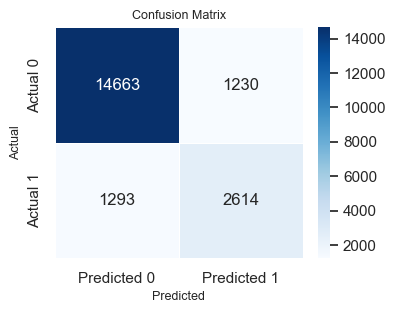

ROC AUC: 0.836


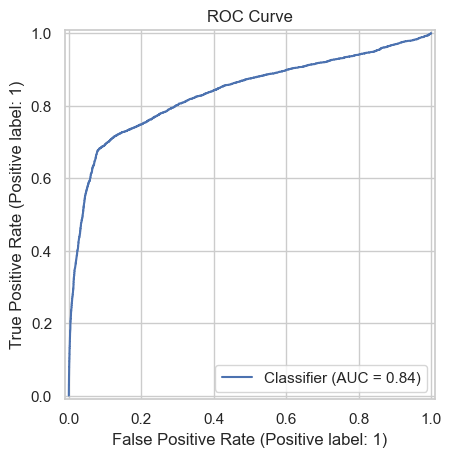

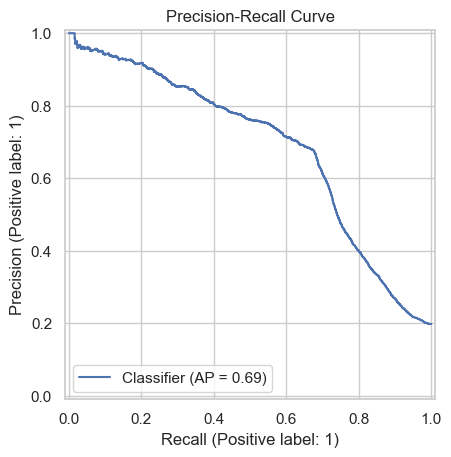

In [58]:
# Apply Logistic Regression model to the dataset. Apply class weight balance to adjust the weights inversely proportional to class frequencies in the input data.
lr_model = LogisticRegression(solver='liblinear', max_iter=500, random_state=42, class_weight='balanced')
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
train_evaluate_model(lr_model, X, y, param_grid=lr_param_grid, feature_selection=True)

#### Observations:
#### 1. Performance has improved slightly as compared to Baseline model.
#### 2. Recall has increased from 62% to 67% and F1 Score has improved to 67%.

In [59]:
#save_model(lr_model2, "Log_reg_model.pkl")

In [60]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#save_model(X_train, "Training_Data.pkl")

Precision: 0.671
Recall: 0.680
F1 Score: 0.676

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     15893
           1       0.67      0.68      0.68      3907

    accuracy                           0.87     19800
   macro avg       0.80      0.80      0.80     19800
weighted avg       0.87      0.87      0.87     19800



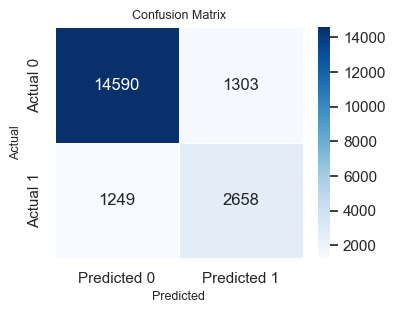

ROC AUC: 0.842


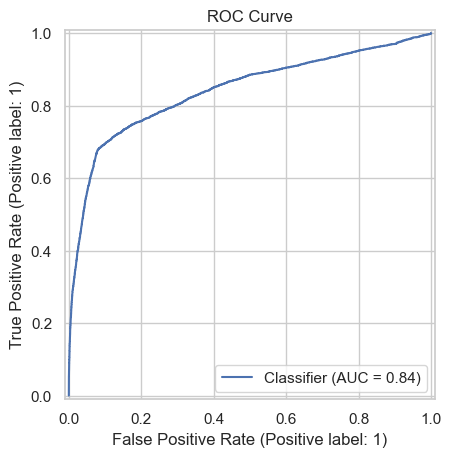

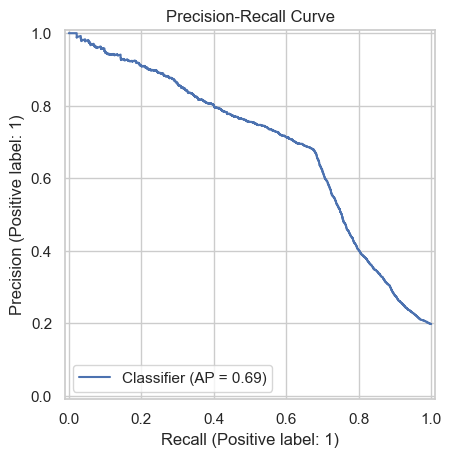

In [61]:
lr_model2 = LogisticRegression(solver='liblinear', max_iter=500, random_state=42, class_weight='balanced')
train_evaluate_model(lr_model2, X, y)

#### Observations:
#### 1. Without hyperparameter tuning, it is as good as the tuned model's performance.
#### 2. Recall has increased to 68% and F1 Score has improved to 68%.

### 4.1.2 Random Forest

Precision: 0.690
Recall: 0.606
F1 Score: 0.645

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     15893
           1       0.69      0.61      0.65      3907

    accuracy                           0.87     19800
   macro avg       0.80      0.77      0.78     19800
weighted avg       0.86      0.87      0.87     19800



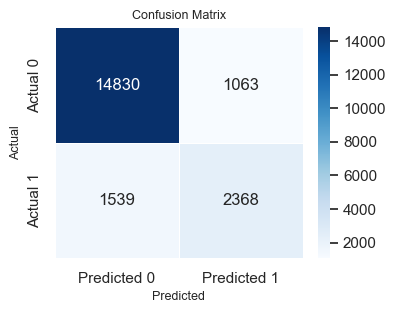

ROC AUC: 0.850


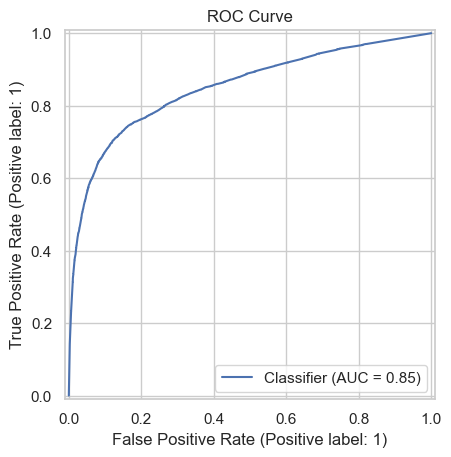

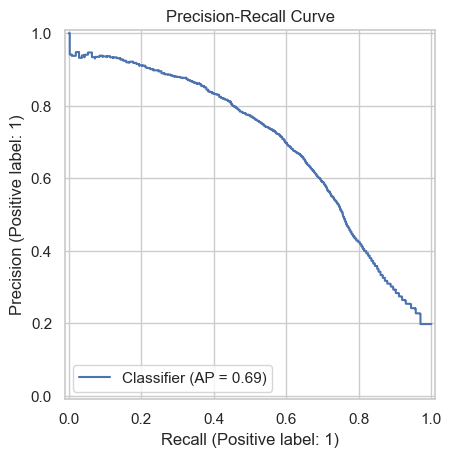

In [62]:
rf_model = RandomForestClassifier(n_estimators=200 , random_state = 42, class_weight='balanced')
train_evaluate_model(rf_model, X, y)

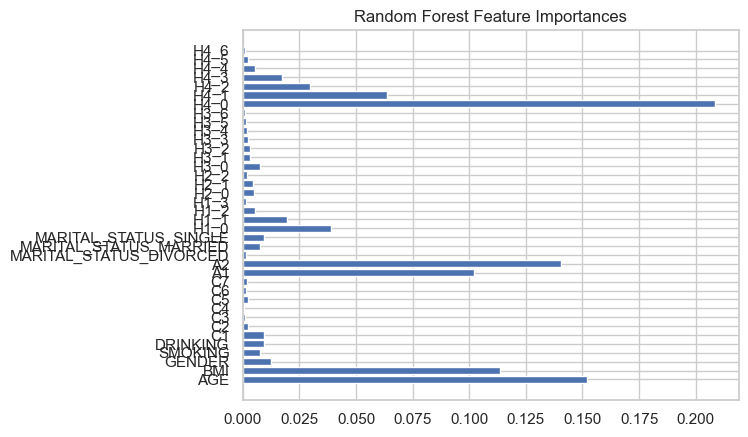

In [63]:
# Plot Random Forest feature importances from the given data
plt.barh(X.columns, rf_model.feature_importances_)
plt.title("Random Forest Feature Importances")
plt.show()

#### Observations: 
#### 1. Recall is 60% which is improvement over baseline model but lower than logistic regression. Similar for F1 Score.
#### 2. There are few important variables like H4 (was identified as important in correlation analysis), Age, A1, A2, BMI.
#### 3. A1 and A2 had higher correlation amongst them. Need to check by removing one of them.
#### 4. Need to fine tune the model by changing parameters like max_depth, max_leaf_nodes etc.
#### 5. Slight improvement in ROC AUC Score.

### 4.1.3 Gradient Boosting

Precision: 0.743
Recall: 0.609
F1 Score: 0.669

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     15893
           1       0.74      0.61      0.67      3907

    accuracy                           0.88     19800
   macro avg       0.83      0.78      0.80     19800
weighted avg       0.88      0.88      0.88     19800



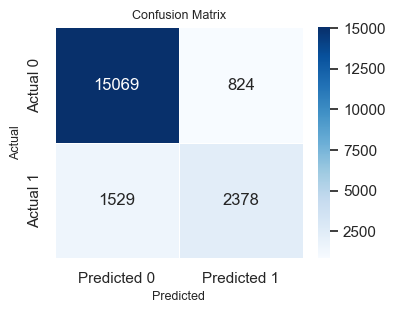

ROC AUC: 0.869


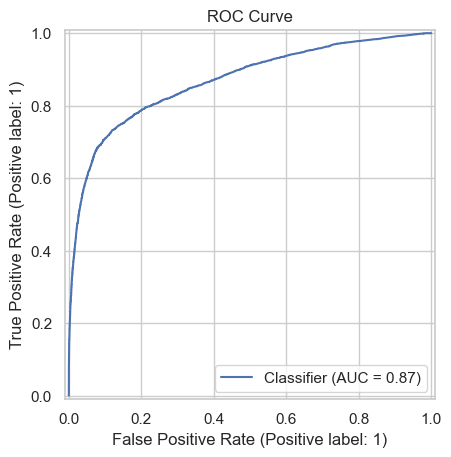

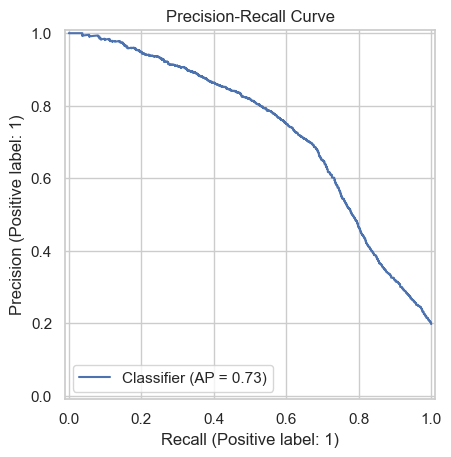

In [64]:
# Fit the model with the some parameters and evaluate the performance
GB_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
train_evaluate_model(GB_model, X, y)

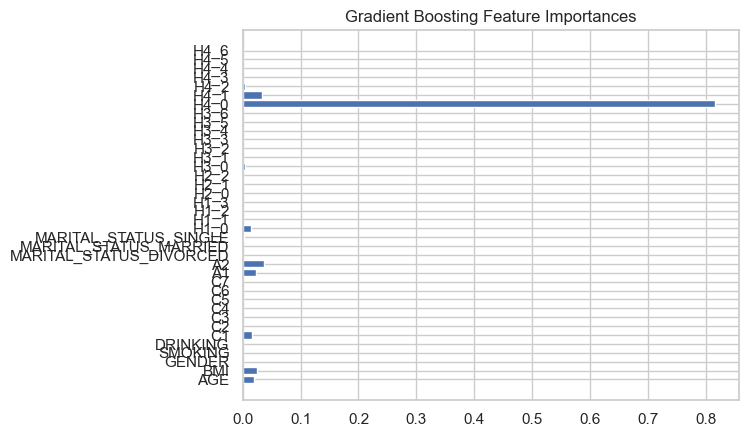

In [65]:
# Plot Gradient Boosting model feature importances from the given data
plt.barh(X.columns, GB_model.feature_importances_)
plt.title("Gradient Boosting Feature Importances")
plt.show()

#### Observations: 
#### 1. Recall and F1 Score are higher than baseline and random forests, but less than logistic regression model.
#### 2. ROC AUC Score has improved in this case.
#### 3. Need to fine tune the model by changing parameters.
#### 4. As per Gradient Boosting model, H4 is important variable.

### 4.2 With Sampling

In [66]:
# As the data is imbalanced, it would be better to make it balanced with sampling techniques. SMOTE is used here to balance it by creating synthetic entries.
X, y = SMOTE().fit_resample(X, y)

### 4.2.1 Logistic Regression

c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Precision: 0.899
Recall: 0.685
F1 Score: 0.777

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82     15894
           1       0.90      0.68      0.78     15893

    accuracy                           0.80     31787
   macro avg       0.82      0.80      0.80     31787
weighted avg       0.82      0.80      0.80     31787



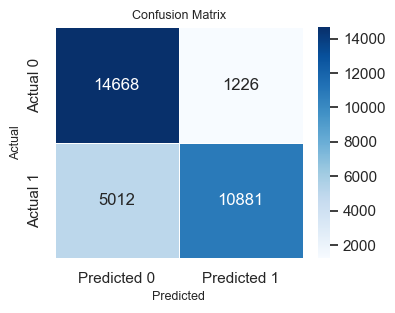

ROC AUC: 0.842


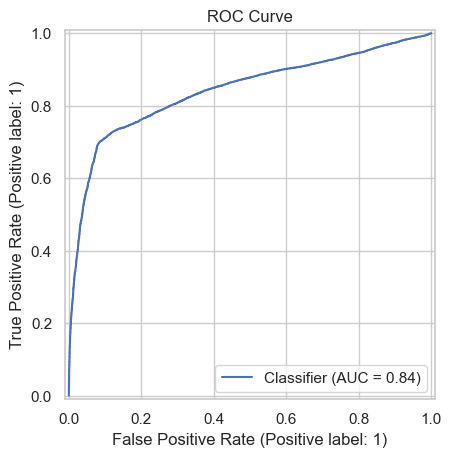

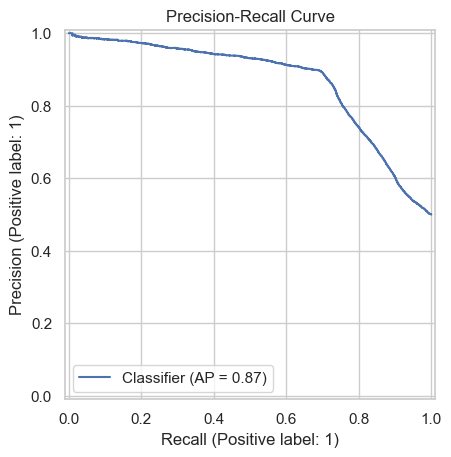

In [67]:
# Apply Logistic Regression model to the dataset. Apply class weight balance to adjust the weights inversely proportional to class frequencies in the input data.
lr_model_samp = LogisticRegression(solver='liblinear', max_iter=500, random_state=42, class_weight='balanced')
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
train_evaluate_model(lr_model_samp, X, y, param_grid=lr_param_grid, feature_selection=True)

#### Observations: 
#### 1. F1 Score, Recall and Precision has improved as compared to previous models.
#### 2. ROC AUC Score is high as well.

### 4.2.2 Random Forest

c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Precision: 0.904
Recall: 0.859
F1 Score: 0.881

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     15894
           1       0.90      0.86      0.88     15893

    accuracy                           0.88     31787
   macro avg       0.88      0.88      0.88     31787
weighted avg       0.88      0.88      0.88     31787



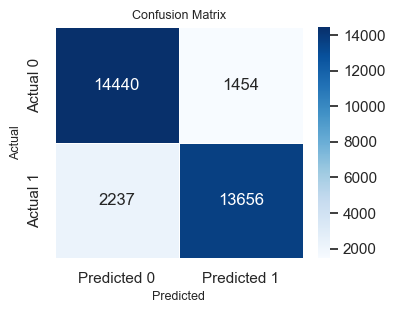

ROC AUC: 0.945


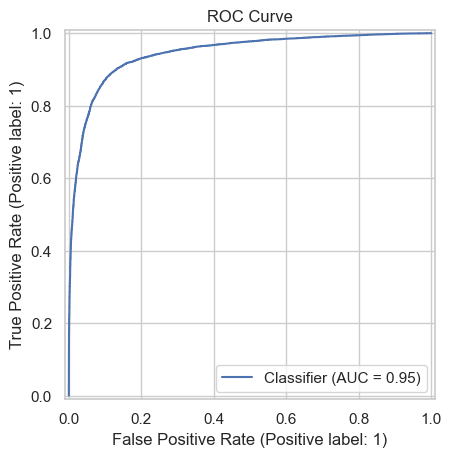

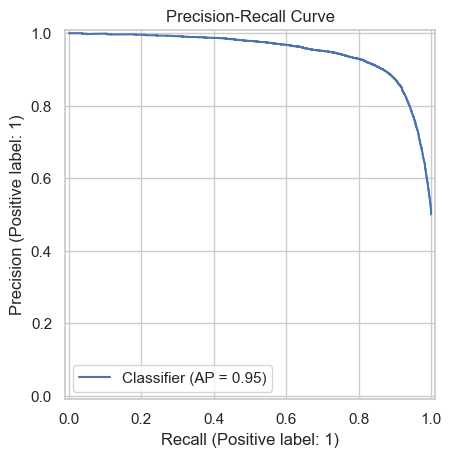

In [68]:
# Define parameter grid for Random Forest Model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Define Random Forest Model
rf_model_samp = RandomForestClassifier(random_state = 42, class_weight='balanced')

# Train and Evaluate the Random Forest Model based on the parameter grid and feature selection 
train_evaluate_model(rf_model, X, y, param_grid=rf_param_grid, feature_selection=True)

#### Observations:
#### 1. Performance of all metrics has improved for all metrics compared to all previous models.
#### 2. Sampling seems to have improved the model performance.

### 4.2.3 Gradient Boosting

c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Megha\PycharmProjects\pythonProject\myenv\Lib\site-packages\sklearn\base.py", line 666, in 

Precision: 0.935
Recall: 0.872
F1 Score: 0.903

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     15894
           1       0.94      0.87      0.90     15893

    accuracy                           0.91     31787
   macro avg       0.91      0.91      0.91     31787
weighted avg       0.91      0.91      0.91     31787



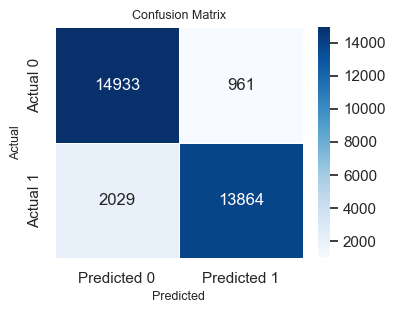

ROC AUC: 0.957


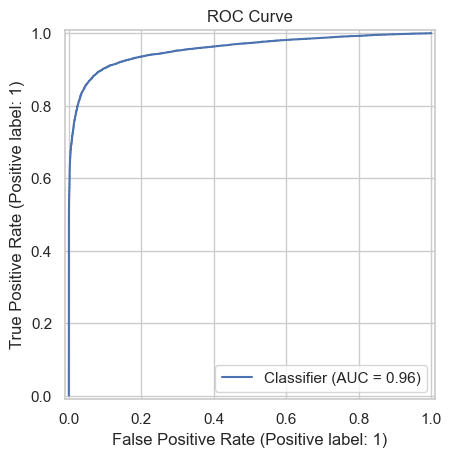

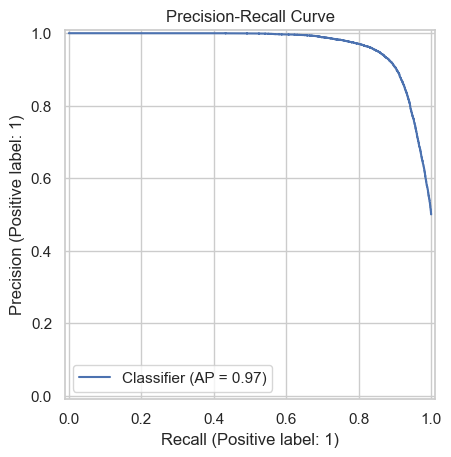

In [69]:
# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Fit the Gradient Boosting model with some parameters and train and evaluate the performance
GB_model = GradientBoostingClassifier(random_state=42)
train_evaluate_model(GB_model, X, y, param_grid=gb_param_grid, feature_selection=True)

#### Observations:
#### 1. Gradient Boosting model performance is the best till now amongst the models tried so far.
#### 2. Sampling and feature selection does improve the model performance.

### 4.2.3 XGBoost

Precision: 0.917
Recall: 0.855
F1 Score: 0.885

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     15894
           1       0.92      0.85      0.89     15893

    accuracy                           0.89     31787
   macro avg       0.89      0.89      0.89     31787
weighted avg       0.89      0.89      0.89     31787



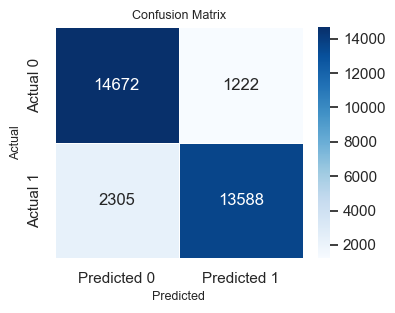

ROC AUC: 0.949


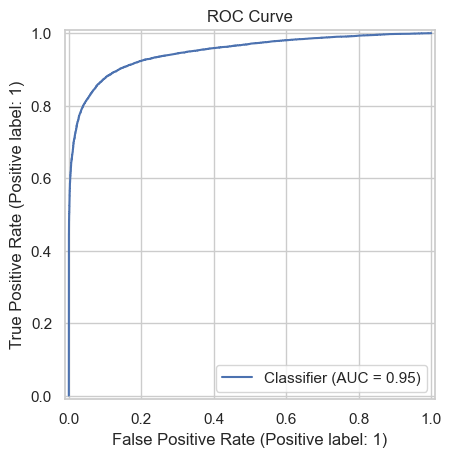

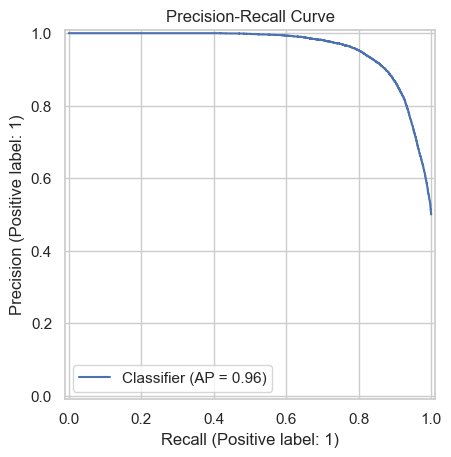

In [70]:
# Define grid of parameters for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 1, 5]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train and evaluate the model
train_evaluate_model(xgb_model, X, y, param_grid=xgb_param_grid, feature_selection=True)

#### Observations: 
#### 1. Performance is almost same as that of Random forest model.
#### 2. Less than Gradient Boosting model.

### 4.2.3 Ensemble of models

Precision: 0.918
Recall: 0.858
F1 Score: 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     15894
           1       0.92      0.86      0.89     15893

    accuracy                           0.89     31787
   macro avg       0.89      0.89      0.89     31787
weighted avg       0.89      0.89      0.89     31787



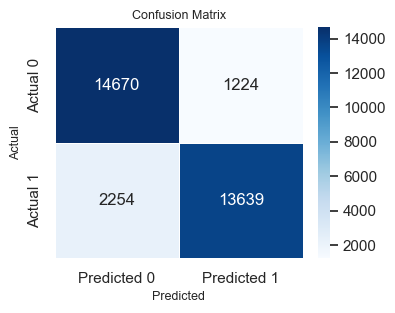

In [74]:
# Create ensemble model using VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('rf', rf_model_samp),
    ('gb', GB_model),
    ('xgb', xgb_model)
], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the ensemble model with training data
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_test)
evaluate_model_performance(y_test, y_pred)

#### Observations: 
#### 1. Gradient Boosting model outperforms ensemble of 3 models.

### Final thoughts and Summary:
### 1. Sampling techniques seem to improve the model performance.
### 2. With sampling, tree based models perform better. Random forest gives the best model performance.
### 3. Without sampling, logistic regression performs better than tree based models.
### 4. Because of the imbalance in the target variable of the dataset, Recall and F1 Score , ROC AUC Score are better metrics.
### 5. Cross validation was also used.
### 6. Feature importance shows that H4 is the most important variable in the dataset. Besides, Age, BMI, A1, A2 are also important variables to identify the risk.
### 7. Isolation Forest does not perform well on the dataset even if after giving contamination parameter.